# C - End-to-End ML Part 2: Decision Tree

Environment für dieses Notebook: `ads-ml-full` (*requirements-py3.11-ads-ml-full.txt*).


## Daten einlesen

In [3]:
from repml.datasets.trees_ber import prepare_trees_ber

_, labeled, _ = prepare_trees_ber()

In [4]:
labeled.sample(5, random_state=123)

,kennzeich,namenr,art_dtsch,art_bot,gattung_deutsch,gattung,stammumfg,bezirk,eigentuemer,pflanzjahr,...,namenr_nonum,lon_section,lat_section,hoehe_zu_krone,hoehe_zu_stamm,baumart,art_dtsch_infrequent,art_bot_infrequent,gattung_deutsch_infrequent,gattung_infrequent
268020,060041,Braunellensteig/ Hornkleepfad Ag GA,rare,rare,APFEL,MALUS,34.0,Treptow-Köpenick,Land Berlin,2012.0,...,Braunellensteig/ Hornkleepfad Ag GA,13.5,52.4,2.0,0.117647,Laubbaum,True,True,False,False
315771,5027,Heidefriedhof Tempelhof,Österreichische Schwarzkiefer,Pinus nigra ssp. Nigra,KIEFER,PINUS,154.0,Tempelhof-Schöneberg,Land Berlin,1978.0,...,Heidefriedhof Tempelhof,13.4,52.4,NaN,0.103896,Nadelbaum,False,False,False,False
198790,109510,Fernsehturmanlage zw. Fernsehturm u. Spandauer...,Spitz-Ahorn,Acer platanoides,AHORN,ACER,50.0,Mitte,Land Berlin,2001.0,...,Fernsehturmanlage zw. Fernsehturm u. Spandauer...,13.4,52.5,NaN,NaN,Laubbaum,False,False,False,False
292819,61001,Sparnecker Weg-Grünverbindung,Silber-Pappel,Populus alba 'Nivea',PAPPEL,POPULUS,129.0,Spandau,Land Berlin,1970.0,...,Sparnecker Weg-Grünverbindung,13.1,52.5,1.6,0.124031,Laubbaum,False,True,False,False
354921,5055,Friedhof Baumschulenweg / Kiefholzstraße 208-2...,Spitz-Ahorn,Acer platanoides,AHORN,ACER,68.0,Treptow-Köpenick,Land Berlin,1950.0,...,Friedhof Baumschulenweg / Kiefholzstraße Ba FH,13.5,52.5,2.4,0.176471,Laubbaum,False,False,False,False


## Trainings- und Testdaten

In [5]:
from sklearn.model_selection import train_test_split

y = "pflanzjahr"
X = labeled.columns.to_list()
X.remove(y)
train_data, test_data = train_test_split(
    labeled, test_size=0.2, random_state=42, stratify=labeled["gattung_deutsch"]
)

## Pipelinedesign & Modellauswahl

In [6]:
cols_subset_2 = ["kronedurch", "stammumfg", "baumhoehe", "bezirk"]

### Versuch 2: Decision Tree

In [7]:
from sklearn import set_config

set_config(transform_output="pandas")

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

ct_2a = ColumnTransformer(
    transformers=[
        ("imp", SimpleImputer(), ["kronedurch", "stammumfg", "baumhoehe"]),
    ],
    remainder="passthrough",
)

In [9]:
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer

ct_2b = ColumnTransformer(
    transformers=[
        (
            "scale",
            QuantileTransformer(output_distribution="normal"),
            ["imp__kronedurch", "imp__stammumfg", "imp__baumhoehe"],
        ),
        ("ohe", OneHotEncoder(sparse_output=False), ["remainder__bezirk"]),
    ],
)

In [10]:
from sklearn.tree import DecisionTreeRegressor

est_2 = DecisionTreeRegressor(max_depth=7, min_samples_split=200, random_state=42)

In [11]:
from sklearn.pipeline import Pipeline

pipeline_2 = Pipeline(steps=[("prep_a", ct_2a), ("prep_b", ct_2b), ("model", est_2)])

In [12]:
pipeline_2.fit(X=train_data[cols_subset_2], y=train_data[y])

Pipeline(steps=[('prep_a',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imp', SimpleImputer(),
                                                  ['kronedurch', 'stammumfg',
                                                   'baumhoehe'])])),
                ('prep_b',
                 ColumnTransformer(transformers=[('scale',
                                                  QuantileTransformer(output_distribution='normal'),
                                                  ['imp__kronedurch',
                                                   'imp__stammumfg',
                                                   'imp__baumhoehe']),
                                                 ('ohe',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['remainder__bezirk'])])),
                ('model',
                 DecisionTreeRegressor(max_depth=7, min_samples_split=200,
                                       random_state=42))])

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(estimator=pipeline_2, X=train_data[cols_subset_2], y=train_data[y], cv=5)

array([0.71720241, 0.71960062, 0.71148782, 0.71257199, 0.70981559])

In [14]:
pipeline_2.score(X=test_data[cols_subset_2], y=test_data[y])

0.7113487156285256

### Decision Tree Visualisierung

GrapViz muss sowohl als Python Paket wie auch auf dem Rechner selbst installiert sein. Im Falle des folgenden Errors muss graphviz noch installiert werden.

```bash
InvocationException: GraphViz's executables not found
``````

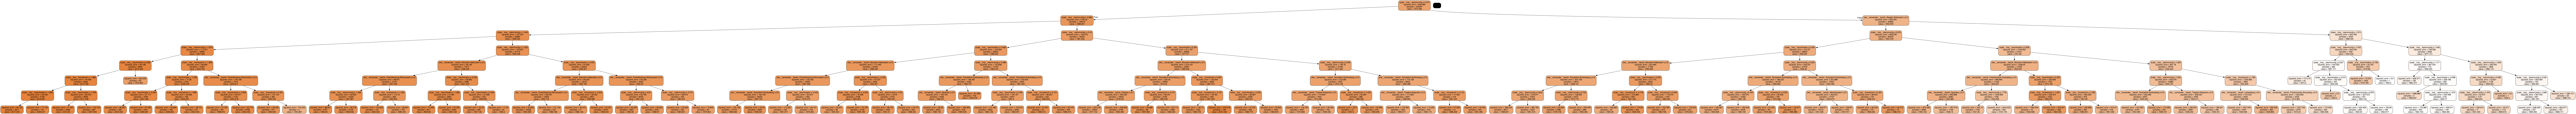

In [21]:
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz

dot_data = export_graphviz(
    pipeline_2.named_steps["model"],
    out_file=None,
    feature_names=pipeline_2.named_steps["prep_b"].get_feature_names_out(),
    filled=True,
    rounded=True,
    special_characters=True,
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Übung
Wie gut performt das Modell gegenüber unserer Baseline mit dem gleichen Set an Features?